This model uses a networked representation of space as the substrate upon which agents move, and trade. (Unlike in the Virus network, in which the nodes themselves were the agents).

In [1]:
import networkx
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

from boltzmann_wealth_model_network.model import BoltzmannWealthModelNetwork

In [52]:
model = BoltzmannWealthModelNetwork(num_agents=7, num_nodes=10)

In [53]:
model.run_model(10) # 10 iterations

In [54]:
model_out = model.datacollector.get_model_vars_dataframe()

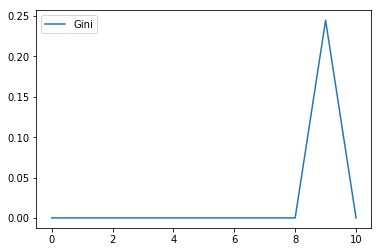

In [55]:
results = model_out.plot()

Go get the Orbis data

In [8]:
!curl https://raw.githubusercontent.com/sfsheath/gorbit/master/gorbit-edges.csv > orbis.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91474  100 91474    0     0   393k      0 --:--:-- --:--:-- --:--:--  393k


In [10]:
import pandas as pd

df = pd.read_csv('orbis.csv')
Graphtype = networkx.Graph()
ORBIS = networkx.from_pandas_edgelist(df, edge_attr='km', create_using=Graphtype)

In [17]:
import random

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import networkx as nx

from mesa.space import NetworkGrid


def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class BoltzmannWealthModelNetwork2(Model):
    """A model with some number of agents."""

    def __init__(self, num_agents=7, num_nodes=10):

        self.num_agents = ORBIS.number_of_nodes()
        self.num_nodes = ORBIS.number_of_nodes()#num_nodes if num_nodes >= self.num_agents else self.num_agents
        self.G = ORBIS #nx.erdos_renyi_graph(n=self.num_nodes, p=0.5)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": lambda _: _.wealth}
        )

        list_of_random_nodes = random.sample(self.G.nodes(), self.num_agents)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random node
            self.grid.place_agent(a, list_of_random_nodes[i])

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        for i in range(n):
            self.step()


class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = [node for node in self.model.grid.get_neighbors(self.pos, include_center=False) if
                          self.model.grid.is_cell_empty(node)]
        if len(possible_steps) > 0:
            new_position = random.choice(possible_steps)
            self.model.grid.move_agent(self, new_position)

    def give_money(self):

        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        neighbors = self.model.grid.get_cell_list_contents(neighbors_nodes)
        if len(neighbors) > 0:
            other = random.choice(neighbors)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


In [56]:
model2 = BoltzmannWealthModelNetwork2(num_agents=1200) # defaults to 1 agent per node, eg 667 agents, nodes

In [60]:
model2.run_model(10) # 10 iterations

In [61]:
model_out2 = model2.datacollector.get_model_vars_dataframe()

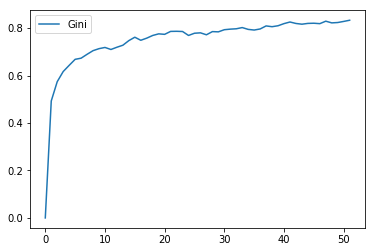

In [62]:
results = model_out2.plot()

In [67]:
from mesa.batchrunner import BatchRunner

fixed_params = dict(num_nodes = ORBIS.number_of_nodes())

# Vary density from 0.01 to 1 by increments; np.linspace takes the start, finish, and then
# number of equal spaced samples to generate within that range. 
variable_params = dict(num_agents=numpy.linspace(600,1200,10)[1:]
                       )

In [71]:
# At the end of each model run, calculate gini
# these take measurements at the end

model_reporter = {"Gini": compute_gini}

In [72]:
param_run = BatchRunner(BoltzmannWealthModelNetwork2, variable_parameters=variable_params, iterations=10, 
                        fixed_parameters=fixed_params, model_reporters=model_reporter)

In [74]:
df = param_run.get_model_vars_dataframe()

In [ ]:
param_run.run_all()

In [75]:
df.head()

,num_agents,Run,Gini,num_nodes
0,666.666667,0,0.947176,677
10,733.333333,0,0.935490,677
1,666.666667,1,0.948022,677
11,733.333333,1,0.944007,677
2,666.666667,2,0.953677,677


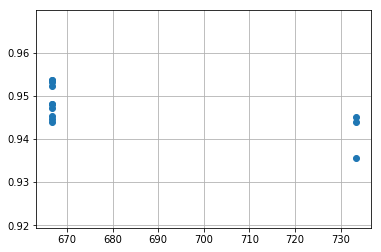

In [76]:
plt.scatter(df.num_agents, df.Gini)
plt.grid(True)